In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable
import csv

# The bathymetry

Configure the extent 

In [2]:
bathymetry_extent = {
    "xmin" : 90, 
    "xmax" :  325.83,
    "ymin" :  -85,
    "ymax" : 85,
}

In [3]:
nami_extent = {
    "xmin" : 90,
    "xmax" : 325.83,
    "ymin" : -60,
    "ymax" : 70,
}

Bathymetry resolution

In [4]:
ds = 30

Read bathymetry

In [5]:
bathymetry_raw = np.fromfile(f'../data/bathymetry{int(ds)}min',dtype='float64')
bathymetry_shape = np.asarray(bathymetry_raw[:2], dtype=int)    
bathymetry_raw = bathymetry_raw[2:]
bathymetry_raw = bathymetry_raw.reshape(bathymetry_shape)

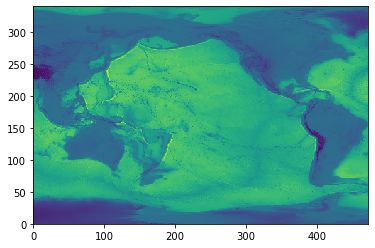

In [6]:
plt.pcolormesh(bathymetry_raw)

Trim parts of the bathymetry not in the domain of Nami

In [7]:
bathymetry_shape

array([340, 472])

In [14]:
lat_start_index = int((nami_extent["ymin"] - bathymetry_extent["ymin"])/(ds/60))
lat_end_index = bathymetry_shape[0] - int((bathymetry_extent["ymax"] - nami_extent["ymax"])/(ds/60))
lon_start_index = int((nami_extent["xmin"] - bathymetry_extent["xmin"])/(ds/60))
lon_end_index = bathymetry_shape[1] - int((bathymetry_extent["xmax"] - nami_extent["xmax"])/(ds/60))-1
print(f"{lat_start_index = }")
print(f"{lat_end_index = }")
print(f"{lon_start_index = }")
print(f"{lon_end_index = }")

lat_start_index = 50
lat_end_index = 310
lon_start_index = 0
lon_end_index = 471


In [15]:
bathymetry = bathymetry_raw[lat_start_index:lat_end_index,lon_start_index:lon_end_index]
nlat, nlon = bathymetry.shape
print(f"nlat = {nlat}, nlon = {nlon}")

nlat = 260, nlon = 471


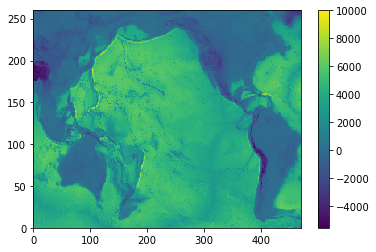

In [16]:
plt.pcolormesh(bathymetry)
plt.colorbar()

# Read max heights and arrival

In [17]:
def read_large_nami_csv(path):
    reader = csv.reader(open(path))

    for row in reader:
        continue

    return np.array(row, dtype=float)

In [18]:
nami_folder = "../tsunamilab/30min"

In [21]:
hmax_unmasked = read_large_nami_csv(f"{nami_folder}/tlab2D.csv").reshape((nlat,-1))
harr_unmasked = read_large_nami_csv(f"{nami_folder}/tlab2D (1).csv").reshape((nlat,-1))

harr = np.ma.masked_where(bathymetry<500, harr_unmasked)
hmax = np.ma.masked_where(bathymetry<10, hmax_unmasked)

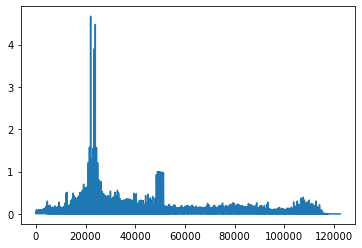

In [22]:
plt.plot(hmax_unmasked.ravel())

In [23]:
np.percentile(hmax_unmasked.ravel(), 90)

0.10955525040626526

In [26]:
x = np.linspace(nami_extent["xmin"], nami_extent["xmax"], nlon)
y = np.linspace(nami_extent["ymin"], nami_extent["ymax"], nlat)
x, y = np.meshgrid(x, y)

Pois locations

In [27]:
[21418,32411,51407,55012]

[21418, 32411, 51407, 55012]

In [28]:
pois={
    21414: [178.219,48.968],
    21419: [155.717,44.435],
    21401: [152.583,42.617],
    21418: [148.645,38.727],
    21413: [152.132,30.533],
    52403: [145.52,4.02],
    52406: [164.977,-5.307],
    55012: [158.453,-15.664],
    51425: [183.68,-9.517],
    51407: [203.455,19.57],
    46404: [231.267,45.853],
    46407: [231.168,42.682],
    46411: [232.933,39.333],
    46412: [239.437,32.492],
    43412: [253.03300000000002,16.045],
    43413: [259.91700000000003,11.012],
    32411: [269.12,4.953],
    32412: [273.626,-17.984],
    32413: [266.483,-7.406],
    32401: [286.579,-20.474],
}
darts_ids = [21413, 32412, 43412, 46404, 46407, 46411, 46412, 51425, 52403]# [21418,32411,51407,55012]
# darts_ids = [21413, 32412, 43412, 46404, 46407, 46411, 46412, 51425, 52403, 21418,32411,51407,55012]

In [29]:
dart_locations = np.array(list(pois.values()))

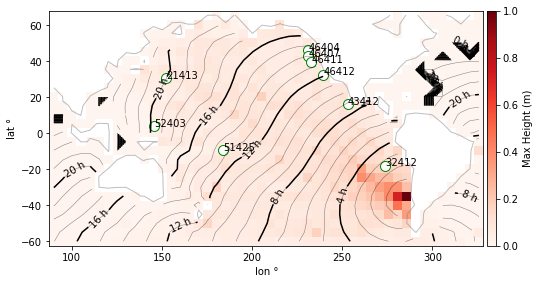

In [38]:
s = 10 #skip size


f = plt.figure(figsize=(8,6))
ax1 = f.add_subplot(111)

p = ax1.pcolormesh(x[::s,::s],y[::s,::s],hmax[::s,::s],vmax=1,vmin=0, cmap=plt.cm.Reds, shading="nearest")
divider = make_axes_locatable(ax1)

for  dart in darts_ids:
    
    [lon, lat] = pois[dart]
    ax1.scatter([lon],[lat],color='white',edgecolor='green',marker='o', s=100)
    ax1.annotate('%s'%dart, [lon+0.1,lat])
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = f.colorbar(p,cax)
cbar.set_label('Max Height (m)')

ax1.contour(x[::s,::s],y[::s,::s], bathymetry[::s,::s], [10], linewidths=1, alpha=0.5, colors='grey')
CS = ax1.contour(x[::s,::s],y[::s,::s],harr[::s,::s]/60/60,np.arange(0,24,4),colors='k')
ax1.clabel(CS, inline=1, fontsize=10, fmt='%i h')
ax1.contour(x[::s,::s],y[::s,::s],harr[::s,::s]/60/60,
            np.arange(0,24,1),colors='k', linewidths=0.5, alpha=0.5)

ax1.set_aspect(1)
ax1.set_xlabel('lon °')
ax1.set_ylabel('lat °')
f.savefig('energy2010.png',dpi=300,bbox_inches='tight')

# Time series

Read Nami time series

In [42]:
nami = pd.read_json(f"{nami_folder}/pois")

Read Easywave time series

In [43]:
ewave = pd.read_csv('../easyWave/eWave.poi.ssh', delim_whitespace=True)

Read DART buoys time series

In [44]:
darts = {}
for dart in darts_ids:
    darts[dart] = np.loadtxt('../data/tsunamiDART{}'.format(dart))

In [45]:
starts = {
    21413: 1200,
    32412: 150,
    43412: 550,
    46404: 900,
    46407: 850,
    46411:800,
    46412: 750,
    51425: 800,
    52403: 1250
}

In [46]:
group1 = [32412, 43412, 46412]
group2 = [46411, 46407, 46404]
group3 = [51425, 52403, 21413]
orderedBuoys = [32412, 46411, 51425, 43412, 46407, 52403, 46412, 46404, 21413]
orderedBuoys = [32412, 43412, 46412, 46411, 46407, 51425, 46404, 52403, 21413 ]

In [47]:
for i, d in enumerate(orderedBuoys):
    print(i,d)

0 32412
1 43412
2 46412
3 46411
4 46407
5 51425
6 46404
7 52403
8 21413


In [49]:
yranges = {
    46411: [-0.05, 0.1],
    46404: [-0.1,0.1]
}

In [50]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 6}

matplotlib.rc('font', **font)

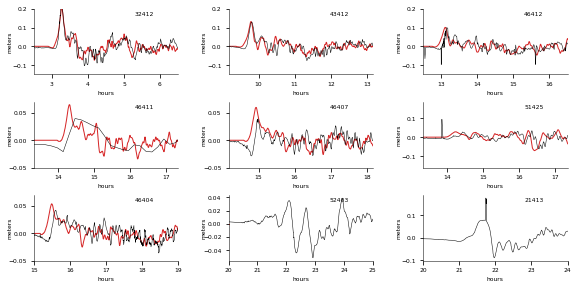

In [55]:
f = plt.figure(figsize=(12/1.5, 6/1.5))
for i, dart_number in enumerate(orderedBuoys):
    ax = f.add_subplot(3,3,i+1)
    
    ax.plot(ewave['Minute']/60., ewave[str(dart_number)],
            label='easywave',color='#d62728', linewidth=1)
    ax.plot(np.array(nami[dart_number].time)/60/60, nami[dart_number].surface,
            label='nami', linewidth=1)
    ax.plot(darts[dart_number][:,0]*24, darts[dart_number][:,1], 
            label='dart buoy', color='k',linewidth=0.5)

    
    xmin = min(starts[dart_number]/60, 20)
    xmax = min(starts[dart_number]/60+4,25)
    ax.set_xlim( xmin, xmax)
    ax.annotate('%s'%dart_number, [0.7,0.9], xycoords='axes fraction')
    ax.yaxis.set_label_coords(-0.15,0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    
    ax.spines['bottom'].set_linewidth(0.5)
    xticks = np.arange(np.ceil(xmin), np.ceil(xmax+0.5), 1, dtype=int)
    ax.set_xticks(xticks)
    if dart_number in group1:
        ax.set_ylim(-0.15,0.2)
        ax.set_yticks(np.arange(-0.1,0.2,0.1))
    elif dart_number in group2:
        ax.set_ylim(-0.05,0.07)
        ax.set_yticks(np.arange(-0.05,0.051,0.05))
    
        
    ax.set_xlabel('hours')
    ax.set_ylabel('meters')

    
f.tight_layout()
f.subplots_adjust(wspace=0.35)
f.savefig('timeseries2010.png',dpi=300, bbox_inches='tight')

In [56]:
!open timeseries2010.png

/bin/bash: open: command not found


32412 43412 46412: súper buen ajuste con las mediciones, en tiempo de arribo y peak, aunque se comienzan a desfasar con l 

luego se desfasan sistemáticamente, quedando siepmre un poco adelante, pero la forma en general y orden de magnitud de las olas está bien, la estimación de máximo también

